In [1]:
from glob import glob
import librosa
import soundfile as sf
import numpy as np
import pandas as pd
import sys
import time
import datetime
from tqdm import tqdm
import yaml
import random
import os
import gc
import cv2

from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, AdamW, lr_scheduler
from torch.distributions import Uniform
from torch.utils.data import DataLoader, Dataset

from torchlibrosa.stft import Spectrogram, LogmelFilterBank
from torchlibrosa.augmentation import SpecAugmentation

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

import sys
sys.path.append('..')
from libs import transform as tr
from libs import spectrogram as spec
from libs import criterion as cr
from libs import wormup as wu


import warnings
warnings.filterwarnings("ignore")

/home/yuigahama/anaconda3/lib/python3.8/site-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

set_seed(42)

In [3]:
with open('../settings/resnext_base.yaml') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
def normalize_melspec(X: np.ndarray):
    eps = 1e-6
    mean = X.mean()
    X = X - mean
    std = X.std()
    Xstd = X / (std + eps)
    norm_min, norm_max = Xstd.min(), Xstd.max()
    if (norm_max - norm_min) > eps:
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def save(fold, model, optim, criterion, file_path="../../model/"):
    if not settings['test_name'] in os.listdir(file_path):
        os.mkdir(file_path+settings['test_name'])
    
    
    output_path = file_path + settings['test_name'] + '/' + f"{settings['test_name']}_{fold}.model"
    
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.cpu().state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'criterion': criterion
        },
        output_path)
    
    model.to(device)
    
    return output_path

In [5]:
class RfcxDataSet(Dataset):
    def __init__(self,
                 tp:pd.DataFrame,
                 train: bool,
                 data_path:str,
                 transform_params:dict,
                 pre_calc=True,
                 n_mels=128
    ):
        self.tp = tp
        self.path = data_path
        self.img_size = 256
        self.train = train
        self.n_mels = n_mels
        self.pre_calc = pre_calc
        
        self.transform = tr.Compose([
            tr.OneOf([
                tr.GaussianNoiseSNR(min_snr=transform_params['GaussianNoiseSNR']),
                tr.PinkNoiseSNR(min_snr=transform_params['PinkNoiseSNR'])
            ]),
            tr.PitchShift(max_steps=transform_params['max_steps'], sr=SR),
            #tr.TimeStretch(),
            #tr.TimeShift(sr=sr),
            tr.VolumeControl(mode="sine")
        ])
        
        
    def __len__(self):
        return len(self.tp)
    
    def load(self, record_path):
        y, orig_sr = sf.read(record_path)
        
        if orig_sr != SR:
            y = librosa.resample(y, orig_sr=orig_sr, target_sr=SR, res_type="kaiser_best")
        return y
    
    def get_random_duration(self, duration=10):
        start_sec = random.randint(0, 60-duration)
        end_sec = start_sec + 10
            
        return start_sec, end_sec
    
    def get_duration(self, t_min, t_max, duration=10):
        annotated_duration = t_max - t_min
        
        if annotated_duration > duration:
            limit_sec = t_max - duration
            start_sec = random.randint(t_min, limit_sec)
            end_sec = start_sec + duration

        else:
            res_time = duration - annotated_duration
            front_limit = res_time if res_time < t_min else t_min
            
            front_time = random.randint(0, front_limit)
            
            back_limit = 60 - t_max
            
            tmp_time = res_time - front_time
            back_time = tmp_time if tmp_time < back_limit else back_limit
            
            if not tmp_time < back_limit:
                front_time += tmp_time - back_limit
            
            start_sec = t_min - front_time
            end_sec = t_max + back_time
            
        return start_sec, end_sec
    
    def create_mel(self, y):
        y = self.transform(y)
        
        melspec = librosa.feature.melspectrogram(
            y,
            sr=SR,
            fmin=0,
            fmax=15000,
            n_mels=128
        )

        pcen = librosa.pcen(melspec, sr=SR, **self.pcen_parameters)
        clean_mel = librosa.power_to_db(melspec ** 1.5)
        melspec = librosa.power_to_db(melspec)

        norm_melspec = normalize_melspec(melspec)
        norm_pcen = normalize_melspec(pcen)
        norm_clean_mel = normalize_melspec(clean_mel)

        image = np.stack([norm_melspec, norm_pcen, norm_clean_mel], axis=-1)

        return image
    
    def __getitem__(self, idx: int):
        sample = self.tp.iloc[idx, :]
        recording_id = sample['recording_id']
        t_min = int(round(sample['t_min']))
        t_max = int(round(sample['t_max']))
        
        start_sec, end_sec = self.get_duration(t_min, t_max, settings['duration'])
            
        record_path = self.path + recording_id + '.flac'
        y = self.load(record_path)
        y =  y[start_sec*SR:end_sec*SR]
        
        if self.train:
            y = self.transform(y)
        
        species_id = sample['species_id']
        target = torch.zeros([24], dtype=torch.float32)
        target[species_id] = 1
        
        return y, target

In [6]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


def do_mixup(x: torch.Tensor, mixup_lambda: torch.Tensor):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0::2].transpose(0, -1) * mixup_lambda[0::2] +
           x[1::2].transpose(0, -1) * mixup_lambda[1::2]).transpose(0, -1)
    return out


class Mixup(object):
    def __init__(self, mixup_alpha, random_seed=1234):
        """Mixup coefficient generator.
        """
        self.mixup_alpha = mixup_alpha
        self.random_state = np.random.RandomState(random_seed)

    def get_lambda(self, batch_size):
        """Get mixup random coefficients.
        Args:
          batch_size: int
        Returns:
          mixup_lambdas: (batch_size,)
        """
        mixup_lambdas = []
        for n in range(0, batch_size, 2):
            lam = self.random_state.beta(self.mixup_alpha, self.mixup_alpha, 1)[0]
            mixup_lambdas.append(lam)
            mixup_lambdas.append(1. - lam)

        return torch.from_numpy(np.array(mixup_lambdas, dtype=np.float32))


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output

In [7]:
class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)


class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [8]:
class resnestSED(nn.Module):
    def __init__(
        self,
        base_model_name: str,
        pretrained=False,
        num_classes=24,
        spectrogram_params={},
        logmel_extractor_params={},
        spec_augmenter_params={},
        pce_params={}
    ):
        super().__init__()
        self.spectrogram_extractor = Spectrogram(**spectrogram_params)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(**logmel_extractor_params)
        
        #Pcen converter
        self.pcen_converter = spec.pcen(**pce_params)

        # Spec augmenter
        #self.spec_augmenter = SpecAugmentation(**spec_augmenter_params)
        
        self.interpolate_ratio = 30  # Downsampled ratio
        self.mixup_alpha = 0.2
        self.random_state = np.random.RandomState(123)
        
        base_model = torch.hub.load("zhanghang1989/ResNeSt",
                                    base_model_name,
                                    pretrained=pretrained)
        layers = list(base_model.children())[:-2]
        self.encoder = nn.Sequential(*layers)

        in_features = base_model.fc.in_features

        self.fc1 = nn.Linear(in_features, in_features, bias=True)
        self.att_block = AttBlockV2(in_features, num_classes, activation="sigmoid")

        self.init_weight()
        
    def mixup(self, x):
        sizws = x.size()
        #lam = torch.from_numpy(self.random_state.beta(self.mixup_alpha, self.mixup_alpha, (sizws[0], 1))).cuda()
        lam = self.random_state.beta(self.mixup_alpha, self.mixup_alpha, 1)[0]
        index = list(range(x.size(0)))
        random.shuffle(index)
        #out = (x.view(sizws[0], -1) * lam + x[index].squeeze().view(sizws[0], -1) * (1-lam)).view(sizws[0], sizws[1], sizws[2], sizws[3],)
        out = (x * lam + x[index].squeeze() * (1-lam))
        return out.float(), {'lam': lam, 'index': index}

    def init_weight(self):
        init_layer(self.fc1)

    def forward(self, input):        
        x = self.spectrogram_extractor(input)
        x = self.logmel_extractor(x)
        
        x_mels = self.logmel_extractor.power_to_db(x)
        x_pcen = self.pcen_converter(x) 
        x_clear = self.logmel_extractor.power_to_db(x ** 1.5)
        
        
        x = torch.cat((x_mels,x_pcen,x_clear),1)
        #x = torch.cat((x,x,x),1)
        
        frames_num = x.size(2)
        
        if self.training:
            x, mix_info = self.mixup(x)
            #x = self.spec_augmenter(x)
        else:
            mix_info = None
                
        # (batch_size, channels, freq, frames)
        x = self.encoder(x)

        # (batch_size, channels, frames)
        x = torch.mean(x, dim=3)

        # channel smoothing
        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        logit = torch.sum(norm_att * self.att_block.cla(x), dim=2)
        segmentwise_logit = self.att_block.cla(x).transpose(1, 2)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        framewise_logit = interpolate(segmentwise_logit, self.interpolate_ratio)
        framewise_logit = pad_framewise_output(framewise_logit, frames_num)

        output_dict = {
            "framewise_output": framewise_output,
            "segmentwise_output": segmentwise_output,
            "logit": logit,
            "framewise_logit": framewise_logit,
            "clipwise_output": clipwise_output
        }

        return output_dict, mix_info

In [9]:
# LRAP. Instance-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = (scores.sum(-1) / labels.sum(-1)).mean()
    return score.item()

# label-level average
# Assume float preds [BxC], labels [BxC] of 0 or 1
def LWLRAP(preds, labels):
    # Ranks of the predictions
    ranked_classes = torch.argsort(preds, dim=-1, descending=True)
    # i, j corresponds to rank of prediction in row i
    class_ranks = torch.zeros_like(ranked_classes)
    for i in range(ranked_classes.size(0)):
        for j in range(ranked_classes.size(1)):
            class_ranks[i, ranked_classes[i][j]] = j + 1
    # Mask out to only use the ranks of relevant GT labels
    ground_truth_ranks = class_ranks * labels + (1e6) * (1 - labels)
    # All the GT ranks are in front now
    sorted_ground_truth_ranks, _ = torch.sort(ground_truth_ranks, dim=-1, descending=False)
    # Number of GT labels per instance
    num_labels = labels.sum(-1)
    pos_matrix = torch.tensor(np.array([i+1 for i in range(labels.size(-1))])).unsqueeze(0)
    score_matrix = pos_matrix / sorted_ground_truth_ranks
    score_mask_matrix, _ = torch.sort(labels, dim=-1, descending=True)
    scores = score_matrix * score_mask_matrix
    score = scores.sum() / labels.sum()
    return score.item()

def mixup_loss(cor, x, y, mix_info):
    clip_loss = cor(x['clipwise_output'], y) * mix_info['lam'] + cor(x['clipwise_output'], y[mix_info['index']].squeeze()) * (1-mix_info['lam'])
    frame_loss = cor(x['framewise_output'].max(dim=1)[0], y) * mix_info['lam'] + cor(x['framewise_output'].max(dim=1)[0], y[mix_info['index']].squeeze()) * (1-mix_info['lam'])
    return 0.5*clip_loss+frame_loss

def mixup_socre(cor, x, y, mix_info):
    return cor(x, y) * mix_info['lam'] + cor(x, y[mix_info['index']].squeeze()) * (1-mix_info['lam'])

In [10]:
train_tp = pd.read_csv('../../data/train_tp.csv')
train_fp = pd.read_csv('../../data/train_fp.csv')
submission = pd.read_csv('../../data/sample_submission.csv')

pred_target = list(submission.columns)[1:]
SR = settings['SR']

skf = StratifiedKFold(n_splits=settings['n_splits'], shuffle=True, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
tta = np.zeros((len(submission), 24))
cv_score = 0

for fold_id, (train_index, val_index) in enumerate(skf.split(train_tp, train_tp.species_id)):
    print(f'---------- fold {fold_id} ----------')
    
    model = resnestSED(**settings['model_params']).to(device)
    optim = Adam(model.parameters(), **settings['optim_params'])
    #scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optim, **scheduler_params)
    #scheduler = lr_scheduler.CosineAnnealingLR(optimizer=optim, T_max=epochs-10)
    scheduler = wu.SimpleCosineAnnealingWarmup(optim, **settings['scheduler_params'])
    
    #pos_weights = torch.ones(24)
    #pos_weights = pos_weights * 24
    #criterion = nn.BCELoss()#pos_weight=pos_weights)
    #criterion = FocalLoss()
    criterion = cr.ImprovedFocalLoss(settings['loss_params'])
    
    train_dataset = RfcxDataSet(train_tp.iloc[train_index], **settings['train_params'])
    val_dataset   = RfcxDataSet(train_tp.iloc[val_index], **settings['val_params'])

    train_dataloader = DataLoader(train_dataset, shuffle=True, **settings['dataloder_params'])
    val_dataloader = DataLoader(val_dataset, shuffle=False, **settings['dataloder_params'])
    
    es = 50
    bast_score = 0
    for epoch in range(1, settings['epochs']):
        if es <= 0:
            break
        
        start_time = time.time()
        
        # train
        model.train()
        train_loss = 0
        train_score = 0
        train_corr = 0
        
        for data in train_dataloader:
            image = data[0].float().to(device)
            label = data[1]
            
            optim.zero_grad()
            output, mix_info = model(image)
            
            output = {k:v.cpu() for k,v in output.items()}
            pred_labels = output["framewise_output"].max(1)[0]
            
            loss = mixup_socre(criterion, output, label, mix_info)
            #loss = mixup_socre(criterion, output['clipwise_output'], label, mix_info)
            #loss = criterion(output[''], label, mix_info)
            score = mixup_socre(LWLRAP, pred_labels, label, mix_info)
            
            #score = LWLRAP(pred_labels, label)
                        
            loss.backward()
            optim.step()
            
            vals, answers = torch.max(pred_labels, 1)
            vals, targets = torch.max(label, 1)
            vals, targets2 = torch.max(label[mix_info['index']], 1)
            
            corrects = 0
            for i in range(0, len(answers)):
                if answers[i] == targets[i]:
                    corrects = corrects + 1
                if answers[i] == targets2[i]:
                    corrects = corrects + 1
                
                corrects = 1 if corrects > 0 else 0
                    
            
            train_corr += corrects
            train_loss += loss.item()
            train_score += score
            
        train_loss  /= len(train_dataloader)
        train_score /= len(train_dataloader)
        
        # val
        model.eval()
        val_loss = 0
        val_score = 0
        val_corr = 0

        with torch.no_grad():
            for val_data in val_dataloader:
                image = val_data[0].float().to(device)
                label = val_data[1]

                output, mix_info = model(image)
                output = {k:v.cpu() for k,v in output.items()}
                
                pred_labels = output["framewise_output"].max(1)[0]
                vals, answers = torch.max(pred_labels, 1)
                vals, targets = torch.max(label, 1)
                
                corrects = 0
                for i in range(0, len(answers)):
                    if answers[i] == targets[i]:
                        corrects = corrects + 1

                val_corr += corrects
                val_loss += criterion(output, label)
                val_score += LWLRAP(pred_labels, label)
                
        val_loss  /= len(val_dataloader)
        val_score /= len(val_dataloader)
        
        duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]
        print(f'E {epoch:3}| T | L: {train_loss:.3} | S: {train_score:.3} | C: {train_corr}/{len(train_dataset)} | V | L: {val_loss:.3} | S: {val_score:.3} | C: {val_corr}/{len(val_dataset)} | T: {duration} | es: {es}')

        if bast_score < val_score:
            bast_score = val_score
            bast_path = save(fold_id, model, optim, criterion)
        else:
            es -= 1
        
        if es <= 0:
            break
            
        scheduler.step(val_score)
    
    print(f"bast score: {bast_score}")
    cv_score += bast_score / settings['n_splits']
    del model, train_dataset, val_dataset, train_dataloader, val_dataloader, optim
    gc.collect()

---------- fold 0 ----------


KeyboardInterrupt: 

In [ ]:
print(cv_score)

In [11]:
def check_inside_tp(df, start, end):
    for i in range(len(df)):
        sample = df.iloc[i]
        
        if start < sample['t_min'] < end:
            return True
        elif start < sample['t_max'] < end:
            return True
    
    return False

def check_inside_fp(df, start, end, id_):
    for i in range(len(df)):
        sample = df.iloc[i]
        sample_id = sample['species_id']
        
        if sample_id != id_:
            continue
        
        if start < sample['t_min'] < end:
            return True
        elif start < sample['t_max'] < end:
            return True
    
    return False

In [26]:
def prediction_for_clip(audio_id: str,
                        tp_info: pd.DataFrame,
                        fp_info: pd.DataFrame,
                        clip: np.ndarray, 
                        model: resnestSED,
                        threshold=0.5):
    PERIOD = settings['duration']
    audios = []
    y = clip.astype(np.float32)
    len_y = len(y)
    start = 0
    end = PERIOD * SR
    while True:
        y_batch = y[start:end].astype(np.float32)

        start += 3 * SR
        end += 3 * SR
        
        #mel = create_mel(y_batch)
        audios.append(y_batch)
        
        if len_y < end:
            break
            
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    array = np.asarray(audios)
    image = torch.from_numpy(array).to(device)
    
    model.eval()
    estimated_event_list = []
    global_time = 0.0
    

    with torch.no_grad():
        prediction, _ = model(image)
        
        predictions_sig = torch.sigmoid(torch.max(prediction["framewise_output"], 1)[0]).detach().cpu().numpy()

        for i, ps in enumerate(predictions_sig):
            target_ind = np.where(ps > threshold)[0].tolist()
            if len(target_ind) == 0:
                continue
            
            for tmp_id in target_ind:
                tmp_start = (i * 3) - 1 if i != 0 else 0
                tmp_end = tmp_start + PERIOD + 1 if tmp_start + PERIOD + 1 < 60 else 60
                
                if tmp_id == tp_info['species_id'].iloc[0]:
                    continue
                
                if not all([
                    check_inside_tp(tp_info, tmp_start, tmp_end), 
                    check_inside_fp(fp_info, tmp_start, tmp_end, tmp_id)
                ]):
                    estimated_event_list.append(
                        {
                            "recording_id": audio_id,
                            "species_id": tmp_id,
                            "songtype_id": None,
                            "t_min": tmp_start, "t_max": tmp_end,
                            "f_min": None, "f_max": ps[tmp_id]
                        }
                    )
    return estimated_event_list

In [27]:
def prediction(tp_df: pd.DataFrame,
               fp_df: pd.DataFrame,
               model: dict,
               threshold=0.5):
    unique_audio_id = tp_df.recording_id.unique()

    warnings.filterwarnings("ignore")
    prediction_dfs = []
    frame_dict = dict()
    
    for audio_id in tqdm(unique_audio_id):
        tp_info = tp_df.query(f"recording_id == '{audio_id}'")
        fp_info = fp_df.query(f"recording_id == '{audio_id}'")
        
        clip, _ = sf.read(f'/home/yuigahama/kaggle/rfcx/data/train/{audio_id}.flac')

        prediction_df = prediction_for_clip(
            audio_id,
            tp_info,
            fp_info,
            clip=clip,
            model=model,
            threshold=threshold
        )
        prediction_dfs.extend(prediction_df)
    
    return pd.DataFrame(prediction_dfs)

In [28]:
preds = []
frams = [] 
for i in range(5):

    model = resnestSED(**settings['model_params']).to(device)
    params = torch.load(f'/home/yuigahama/kaggle/rfcx/model/{settings["test_name"]}_0886/{settings["test_name"]}_{i}.model')
    model.load_state_dict(params['model_state_dict'])
    
    prediction_df = prediction(
        train_tp,
        train_fp,
        model=model,
        threshold=0.7
    )
    preds.append(prediction_df)

Using cache found in /home/yuigahama/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 1132/1132 [02:59<00:00,  6.32it/s]
Using cache found in /home/yuigahama/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 1132/1132 [02:56<00:00,  6.43it/s]
Using cache found in /home/yuigahama/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 1132/1132 [02:59<00:00,  6.32it/s]
Using cache found in /home/yuigahama/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 1132/1132 [02:55<00:00,  6.44it/s]
Using cache found in /home/yuigahama/.cache/torch/hub/zhanghang1989_ResNeSt_master
100%|██████████| 1132/1132 [02:53<00:00,  6.53it/s]


In [29]:
f5 = pd.concat(preds)

In [30]:
res = list()
for reco_id in train_tp.recording_id.unique():
    reco_sample = f5.query(f"recording_id =='{reco_id}'")
    for spec_id in reco_sample.species_id.unique():
        spec_sample = reco_sample.query(f"species_id =={spec_id}")
        res.append(
            spec_sample.iloc[np.where(spec_sample['f_max'].max() == spec_sample['f_max'].to_numpy())[0]]
        )

In [31]:
pd.concat(res).to_csv('../../data/train_sub.csv', index=False)

In [32]:
tmp = pd.concat(res)
tmp

,recording_id,species_id,songtype_id,t_min,t_max,f_min,f_max
0,006ab765f,5,None,17,24,None,0.707260
2,0099c367b,6,None,11,18,None,0.711408
3,00b404881,21,None,50,57,None,0.724524
5,00d442df7,8,None,29,36,None,0.705113
7,011f25080,4,None,44,51,None,0.706055
...,...,...,...,...,...,...,...
1568,fea6b438a,21,None,29,36,None,0.725527
1970,ff2eb9ce5,18,None,41,48,None,0.705405
1971,ffb8d8391,18,None,53,60,None,0.705331
1523,ffb9a7b9a,9,None,14,21,None,0.725647


<AxesSubplot:>

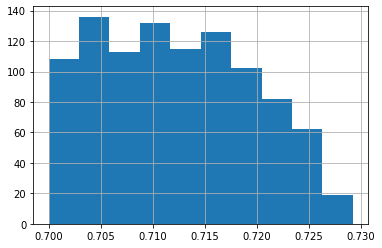

In [25]:
tmp['f_max'].hist()

In [ ]:
sub = pd.DataFrame(np.zeros((len(submission), 24)),columns=pred_target, index=submission['recording_id'])
for p,j in zip(frams, [0.2, 0.2, 0.2, 0.2, 0.2]):
    p.columns = pred_target
    sub += (p * j)
#sub /= 5
sub.reset_index().to_csv(f'/home/yuigahama/kaggle/rfcx/model/{settings["test_name"]}/submission_{settings["test_name"]}.csv', index=False)
sub

In [ ]:
len(np.arange(7e-5,8.0e-4,8e-5).tolist())

In [ ]:
len(np.arange(1e-5,1.0e-3,7e-5).tolist())

In [ ]:
print(torch.tensor([[1],[2],[3]]).size())
a*torch.tensor([[1],[2],[3]])

In [ ]:
0.000005 == 5e-5

In [ ]:
sum([0.21, 0.21, 0.21, 0.16, 0.21])